In [1]:
import tweepy
import twint
import nltk
from nltk.corpus import stopwords
#from nltk.stem import PorterStemmer
from nltk.stem import Cistem
#from nltk.stem.snowball import GermanStemmer
from nltk.tokenize import TweetTokenizer
#import re
import regex as re
import emoji
import datetime
import glob
import io
import os
import random
import string
import unicodedata
import time
import sys
import pandas as pd
import numpy as np
from scipy import stats
import sklearn
from sklearn.preprocessing import QuantileTransformer
from sklearn.mixture import GaussianMixture as GMM
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from pprint import pprint

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

import tqdm

# Workaround for Jupyter's "This event loop is already running" exception
import nest_asyncio
nest_asyncio.apply()

In [2]:
# Check for GPU availability
if tf.test.gpu_device_name():
    print(tf.test.gpu_device_name())
    print("GPU available.")
else:
    print("GPU not available.")

# Print numpy version
print(np.__version__) ## For LSTM layers to work, numpy must be version 1.19.5 for some reason

tweets = None


/device:GPU:0
GPU available.
1.19.5


In [6]:
#handle = "gecko203"
#handle = "FiatPecunia"
handle = "Erdayastronaut"
batch_size = 32 #16 #4 #= 32
buffer_size = 10000
seed = 42
window_size = 4
embedding_dim = 0 #128 # Must be equal to the dimension of the trained embedding; is set later on
num_ns = 4 # Number of negative samples
sequence_length = 20 #10 TODO: Set to the longest tweet!

# Load both datasets
train_dataset_0 = tf.data.experimental.make_csv_dataset(
    "{}/preproc/train_only_0.csv".format(handle), batch_size=batch_size,
    label_name="rating", select_columns=['rating', 'tweet'],
    num_epochs=1)
test_dataset_0 = tf.data.experimental.make_csv_dataset(
    "{}/preproc/test_only_0.csv".format(handle), batch_size=batch_size,
    label_name="rating", select_columns=['rating', 'tweet'],
    num_epochs=1)
val_dataset_0 = tf.data.experimental.make_csv_dataset(
    "{}/preproc/val_only_0.csv".format(handle), batch_size=batch_size,
    label_name="rating", select_columns=['rating', 'tweet'],
    num_epochs=1)

train_dataset_1 = tf.data.experimental.make_csv_dataset(
    "{}/preproc/train_only_1.csv".format(handle), batch_size=batch_size,
    label_name="rating", select_columns=['rating', 'tweet'],
    num_epochs=1)
test_dataset_1 = tf.data.experimental.make_csv_dataset(
    "{}/preproc/test_only_1.csv".format(handle), batch_size=batch_size,
    label_name="rating", select_columns=['rating', 'tweet'],
    num_epochs=1)
val_dataset_1 = tf.data.experimental.make_csv_dataset(
    "{}/preproc/val_only_1.csv".format(handle), batch_size=batch_size,
    label_name="rating", select_columns=['rating', 'tweet'],
    num_epochs=1)

In [8]:
for feature_batch, label in train_dataset_1.take(1):
    for key, value in feature_batch.items():
        print(f"{key:20s}: {value}")
    print()
    print(f"{'label':20s}: {label}")

tweet               : [b'edl team officially handed control perseveranc crui team controlled rover spac pas month thank hard work las month crui team countdowntomar'
 b'wai anna isn princess mea elsa kind understa she quee anna literally princess'
 b'living dream 9 day go clo hatch head back earth'
 b'yes dietitia need 4year bachelor scienc degree 1year hospital internship continuing educatio credi every year called registered dietitiannutritioni rdn nutritioni don need qualificatio'
 b'ict mini ira day ago tweeted pictur irania spac sui exposed converted nasa hallowee costum mistak proto america rock'
 b'randy pari cag tonigh stressrelief' b'cooking christma day dinn'
 b'good stuff' b'cool'
 b'week four astronau took quick field trip outsid statio crew drago vehicl statio expanded resid arrival soyuz ms18 spacecraf spacetogrou'
 b'know averag america meal travel 15002500 mil get pla verticalfarming one many exponential technologie converging disrup eat futureoffood agricultur'
 b'nano

### Load the Word2Vec-Embedding

In [9]:
emb_df = pd.read_pickle('{}/preproc/gensim_w2v_dict.pkl'.format(handle))
emb_df.head()

,word,vec
0,spac,"[-0.32695767, -0.17167582, 0.011153313, 0.0092..."
1,launch,"[0.08093554, -0.028579453, -0.26883894, 0.1231..."
2,new,"[0.03214778, -0.1227091, 0.085580446, -0.09208..."
3,today,"[-0.17026189, 0.020195112, -0.030954506, 0.138..."
4,amp,"[0.07966693, -0.16393906, -0.0019979428, 0.293..."


In [10]:
print(len(emb_df["word"]))

# Since the StringLookup-Layer or the TextVectorization-Layer prepend two new words ('' and [UNK]),
# we need to "shift" the weight matrix by two by prepending "empty" rows...
# This could lead to problems if we later try to infer on new strings containing
# words which are out of vocabulary... (?)

embedding_matrix = emb_df["vec"]
embedding_dim = len(embedding_matrix[0])
print(embedding_dim)

data = []
print(type(emb_df["vec"][0]))
data.insert(0, np.zeros(embedding_dim))
data.insert(0, np.zeros(embedding_dim))
embedding_matrix = pd.concat([pd.Series(data), embedding_matrix], ignore_index=True)
print(embedding_matrix.head())


#emb_df = pd.concat([pd.DataFrame(data), emb_df], ignore_index=True)
#print(emb_df.head())
#layer = StringLookup(vocabulary=list(emb_df["word"]))
vectorize_layer = TextVectorization(output_sequence_length=sequence_length,
                                    vocabulary=list(emb_df["word"]))

vocab_size = len(vectorize_layer.get_vocabulary())

print(vocab_size)
print(vectorize_layer.get_vocabulary()[:3])

36333
256
<class 'numpy.ndarray'>
0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2    [-0.32695767, -0.17167582, 0.011153313, 0.0092...
3    [0.08093554, -0.028579453, -0.26883894, 0.1231...
4    [0.03214778, -0.1227091, 0.085580446, -0.09208...
dtype: object
36335
['', '[UNK]', 'spac']


In [11]:
def vectorize_text(text, label):
    text = text['tweet']
    return vectorize_layer(text), label

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

# Map all strings to their integer representations
train_dataset_0 = train_dataset_0.map(vectorize_text)
test_dataset_0  = test_dataset_0.map(vectorize_text)
val_dataset_0   = val_dataset_0.map(vectorize_text)

train_dataset_0 = train_dataset_0.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset_0 = test_dataset_0.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset_0 = val_dataset_0.cache().prefetch(buffer_size=AUTOTUNE)


train_dataset_1 = train_dataset_1.map(vectorize_text)
test_dataset_1  = test_dataset_1.map(vectorize_text)
val_dataset_1   = val_dataset_1.map(vectorize_text)

train_dataset_1 = train_dataset_1.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset_1 = test_dataset_1.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset_1 = val_dataset_1.cache().prefetch(buffer_size=AUTOTUNE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## Finally define and train our both regressor models...

In [31]:
def make_basic(sl=20):
    """
    A basic and simple sequential model.
    :param sl: Input sequence length
    :return:
    """
    model = Sequential([
        layers.Input(shape=(sl,), dtype=tf.int32),
        layers.Embedding(vocab_size-0, embedding_dim,
                         embeddings_initializer=Constant(list(embedding_matrix)),
                         #input_length=batch_size, Deprecated?
                         trainable=False,
                         mask_zero=True,
                         name="embedding"),
        #layers.GlobalAvgPool1D(),
        #layers.Bidirectional(layers.LSTM(512)),
       
        #layers.Bidirectional(layers.Dense(64)),
        layers.Dense(64, activation='relu'),
        layers.LSTM(64),
        layers.Flatten(),
        layers.Dense(1)
    ])
    # Functional API
    #inputs = tf.keras.Input(shape=(sl,), dtype=tf.int32, name="tweet")
    #emb    = layers.Embedding(vocab_size-0, embedding_dim,
    #                          embeddings_initializer=Constant(list(embedding_matrix)),
    #                          #input_length=batch_size, Deprecated?
    #                          trainable=True,
    #                          mask_zero=True,
    #                          name="embedding")
    #x = inputs
    #x = emb(x)
    #x = layers.Dense(512, activation='relu')(x)
    #x = layers.Dropout(0.2)(x)
    #x = layers.Dense(256, activation='relu')(x)
    #x = layers.LSTM(64)(x)
    #x = layers.Flatten()(x)
    #x = layers.Dense(128, activation='relu')(x)
    #outputs = layers.Dense(1, activation='sigmoid')(x)

    #model = tf.keras.Model(inputs=inputs, outputs=outputs, name="basic_classifier")

    return model

#def tweedie_loglikelihood(y, y_hat):
#    """
#    Implements the Tweedie loss function which is better suited to extremely skewed data like ours.
#
#    From: https://towardsdatascience.com/tweedie-loss-function-for-right-skewed-data-2c5ca470678f
#    """
#    p = 2 # power hyper-parameter
#
#    loss = - y * tf.pow(y_hat, 1 - p) / (1 - p) + \
#            tf.pow(y_hat, 2 - p) / (2 - p)
#    return tf.reduce_mean(loss)

def tweedieloss(y_true, y_pred):
    """
    An alternative loss function which should handle datasets with outliers better...
    It did not help with our problem.
    From: https://datascience.stackexchange.com/a/55393
    """
    p=0.0 #1.5
    dev = 2 * (tf.pow(y_true, 2-p)/((1-p) * (2-p)) -
                   y_true * tf.pow(y_pred, 1-p)/(1-p) +
                   tf.pow(y_pred, 2-p)/(2-p))
    return tf.reduce_mean(dev)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 256)           9301760   
_________________________________________________________________
dense_26 (Dense)             (None, 20, 64)            16448     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
flatten_8 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 9,351,297
Trainable params: 49,537
Non-trainable params: 9,301,760
_________________________________________________________________


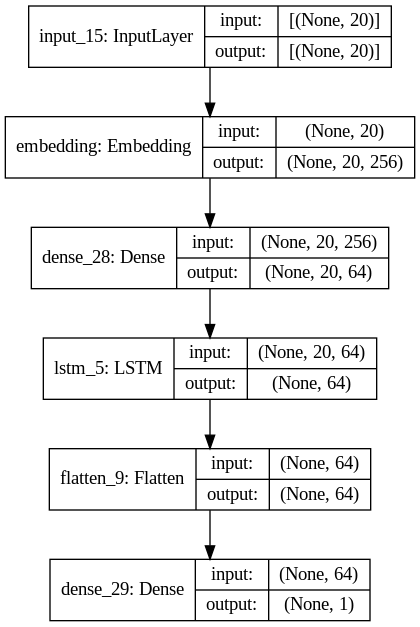

In [35]:
### This model did not work - it predicted constant values for every input!
### -> The reason we need to first classify the input and then perform regression depending on its predicted class.

#model = Sequential([
#    layers.Input(shape=(1,), dtype=tf.string),
#    vectorize_layer,
#    #layers.Embedding(vocab_size, embedding_dim,
#    #                 name="embedding"),
#    layers.Embedding(vocab_size-1, embedding_dim,
#                     embeddings_initializer=Constant(embedding_vectors),
#                     trainable=False,
#                     name="embedding"),
#    #layers.GlobalAvgPool1D(),
#    #layers.Bidirectional(layers.LSTM(512)),
#    #layers.LSTM(64),
#    #layers.Bidirectional(layers.Dense(64)),
#    layers.Dense(64, activation='relu'),
#    #layers.Dense(64, activation='relu'),
#    layers.Dense(1)
#])

#model.compile(loss='mean_absolute_error',
#              optimizer=tf.keras.optimizers.Adam(0.001))


epochs = 20 #100
patience = int(epochs * 0.50) #int(epochs * 0.3)
learning_rate = 1e-3 #1e-2 * 5 #1e-4 * 5
decay_rate = learning_rate / (epochs*epochs)
momentum = 0.8

# The threshold for deciding whether prediction values are 1 or 0 should be
# the value where we have split the data into both bins.
#x_split:
#threshold = 0.2754579724298949
#threshold = 0.3
threshold = 0.25553209091655876 # Erdayastronaut
#threshold = 0.5

#initial_bias = [0.53100804]
initial_bias = [2.89037479] # Erdayastronaut


model0 = make_basic(sl=sequence_length)
model1 = make_basic(sl=sequence_length)

# Compute class weights so that the optimizer doesn't get stuck
# in a local minimum and both classes are balanced.
#labels = np.concatenate([y for x, y in train_dataset], axis=0)
#classWeights = compute_class_weight('balanced', np.unique(labels), labels)
#classWeights = dict(enumerate(classWeights))

loss = tf.keras.losses.MeanAbsoluteError()
opt  = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model0.compile(loss=loss,
               optimizer=opt,
               metrics=[]
               )
model1.compile(loss=loss,
               optimizer=opt,
               metrics=[]
               )

model0.summary()
tf.keras.utils.plot_model(model1, show_shapes=True, to_file='{}_regressor.png'.format(model1.name))

#METRICS = [
#    tf.keras.metrics.TruePositives(name='tp'),
#    tf.keras.metrics.FalsePositives(name='fp'),
#    tf.keras.metrics.TrueNegatives(name='tn'),
#    tf.keras.metrics.FalseNegatives(name='fn'),
#    tf.keras.metrics.Precision(name='precision'),
#    tf.keras.metrics.Recall(name='recall'),
#    tf.keras.metrics.AUC(name='auc'),
#    tf.keras.metrics.AUC(name='prc', curve='PR'),
#    tf.metrics.BinaryAccuracy(threshold=threshold)
#]

In [33]:
test_features_1 = test_dataset_1.map(lambda x, y: x)
test_labels_1 = test_dataset_1.map(lambda x, y: y)
model1.predict(test_features_1)

array([[ 0.12279627],
       [-0.00093571],
       [-0.06458184],
       ...,
       [ 0.09239046],
       [ 0.12903163],
       [ 0.02818967]], dtype=float32)

In [36]:
tf.autograph.set_verbosity(0)
#logging.getLogger("tensorflow").setLevel(logging.ERROR)
early_stopping0 = EarlyStopping(monitor='val_loss', verbose=1, patience=patience)
model_checkpoint0 = ModelCheckpoint('{}/models/regressor0_best.tf'.format(handle),
                                   monitor='val_loss',
                                   #monitor='val_precision', mode='max',
                                   save_format='tf',
                                   #save_format='h5',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1)


history0 = model0.fit(
    train_dataset_0,
    validation_data=val_dataset_0,
    #class_weight=classWeights,
    callbacks=[early_stopping0, model_checkpoint0],
    #steps_per_epoch=steps_per_epoch,
    epochs=epochs
)

Epoch 1/20
914/914 [==============================] - 9s 7ms/step - loss: 0.0095 - val_loss: 5.6667e-04

Epoch 00001: val_loss improved from inf to 0.00057, saving model to Erdayastronaut/models/regressor0_best.tf
Epoch 2/20
914/914 [==============================] - 5s 6ms/step - loss: 4.0836e-04 - val_loss: 1.7677e-04

Epoch 00002: val_loss improved from 0.00057 to 0.00018, saving model to Erdayastronaut/models/regressor0_best.tf
Epoch 3/20
914/914 [==============================] - 5s 6ms/step - loss: 3.2574e-04 - val_loss: 9.0521e-05

Epoch 00003: val_loss improved from 0.00018 to 0.00009, saving model to Erdayastronaut/models/regressor0_best.tf
Epoch 4/20
914/914 [==============================] - 5s 6ms/step - loss: 3.7333e-04 - val_loss: 2.6047e-04

Epoch 00004: val_loss did not improve from 0.00009
Epoch 5/20
914/914 [==============================] - 5s 6ms/step - loss: 3.2453e-04 - val_loss: 8.0424e-05

Epoch 00005: val_loss improved from 0.00009 to 0.00008, saving model to E

In [37]:
early_stopping1 = EarlyStopping(monitor='val_loss', verbose=1, patience=patience)
model_checkpoint1 = ModelCheckpoint('{}/models/regressor1_best.tf'.format(handle),
                                   monitor='val_loss',
                                   #monitor='val_precision', mode='max',
                                   save_format='tf',
                                   #save_format='h5',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1)
history1 = model1.fit(
    train_dataset_1,
    validation_data=val_dataset_1,
    callbacks=[early_stopping1, model_checkpoint1],
    epochs=epochs
)

Epoch 1/20
16465/16465 [==============================] - 96s 6ms/step - loss: 0.0722 - val_loss: 0.0703

Epoch 00001: val_loss improved from inf to 0.07027, saving model to Erdayastronaut/models/regressor1_best.tf
Epoch 2/20
16465/16465 [==============================] - 94s 6ms/step - loss: 0.0702 - val_loss: 0.0699

Epoch 00002: val_loss improved from 0.07027 to 0.06991, saving model to Erdayastronaut/models/regressor1_best.tf
Epoch 3/20
16465/16465 [==============================] - 95s 6ms/step - loss: 0.0698 - val_loss: 0.0698

Epoch 00003: val_loss improved from 0.06991 to 0.06980, saving model to Erdayastronaut/models/regressor1_best.tf
Epoch 4/20
16465/16465 [==============================] - 91s 6ms/step - loss: 0.0697 - val_loss: 0.0698

Epoch 00004: val_loss improved from 0.06980 to 0.06979, saving model to Erdayastronaut/models/regressor1_best.tf
Epoch 5/20
16465/16465 [==============================] - 94s 6ms/step - loss: 0.0695 - val_loss: 0.0698

Epoch 00005: val_loss 

In [ ]:
#saved_model = load_model('{}/models/classificator_best.tf'.format(handle))
#
#_, train_acc = saved_model.evaluate(train_dataset, verbose=1)
#_, test_acc  = saved_model.evaluate(test_dataset, verbose=1)
#
#print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc, test_acc))

Loss (Model0):


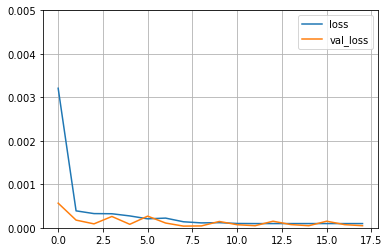

In [47]:
def plot_loss(hist, xlim=0.0, ylim=.3):
    plt.plot(hist.history['loss'], label='loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.ylim([xlim, ylim])
    plt.xlabel=('Epoch')
    plt.ylabel=('Error')
    plt.legend()
    plt.grid(True)

print("Loss (Model0):")
plot_loss(history0, ylim=.005)


Loss (Model1):


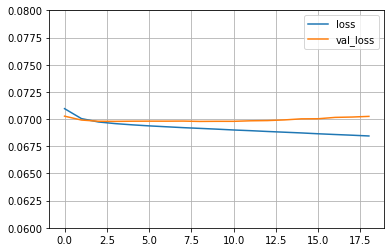

In [49]:
print("Loss (Model1):")
plot_loss(history1, xlim=.06, ylim=.08)

# Evaluate the regressors

In [ ]:
for feature_batch, label in test_dataset_1.take(1):
    for key, value in feature_batch.items():
        print(f"{key:20s}: {value}")
    print()
    print(f"{'label':20s}: {label}")

114/114 [==============================] - 0s 2ms/step - loss: 4.8192e-05
4.819161767954938e-05
2060/2060 [==============================] - 5s 2ms/step - loss: 0.0703
Some labels and their predicted counterparts for regressor0:
        0
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
...   ...
3619  0.0
3620  0.0
3621  0.0
3622  0.0
3623  0.0

[3624 rows x 1 columns]
[[-4.8230537e-05]
 [-4.8230537e-05]
 [-4.8230479e-05]
 ...
 [-4.8227266e-05]
 [-4.8006448e-05]
 [-4.8225185e-05]]
Some labels and their predicted counterparts for regressor1:
              0
0      0.366164
1      0.467537
2      0.439159
3      0.425949
4      0.722285
...         ...
65884  0.366164
65885  0.428204
65886  0.496095
65887  0.590837
65888  0.431289

[65889 rows x 1 columns]
[[0.5012801 ]
 [0.5077152 ]
 [0.5307238 ]
 ...
 [0.5040657 ]
 [0.5172543 ]
 [0.50625914]]


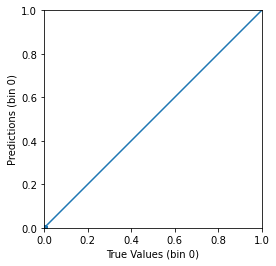

In [55]:
from imp import reload
reload(plt)

history0_dict = history0.history
history1_dict = history1.history

test_results_0 = model0.evaluate(
    test_dataset_0
)
print(test_results_0)

test_results_1 = model1.evaluate(
    test_dataset_1
)

test_features_0 = test_dataset_0.map(lambda x, y: x)
test_labels_0 = test_dataset_0.map(lambda x, y: y)
test_predictions_0 = model0.predict(test_features_0)

test_features_1 = test_dataset_1.map(lambda x, y: x)
test_labels_1 = test_dataset_1.map(lambda x, y: y)
test_predictions_1 = model1.predict(test_features_1)

#print(test_labels)

# Show some predicted values
print("Some labels and their predicted counterparts for regressor0:")
ex0 = test_labels_0.unbatch()
ex0 = pd.DataFrame(ex0)
print(ex0)
print(test_predictions_0)

print("Some labels and their predicted counterparts for regressor1:")
ex1 = test_labels_1.unbatch()
ex1 = pd.DataFrame(ex1)
print(ex1)
print(test_predictions_1)

# Get predictions on the train/test data
train_features_0 = train_dataset_0.map(lambda x, y: x)
train_labels_0 = train_dataset_0.map(lambda x, y: y)
ex2 = train_labels_0.unbatch()
ex2 = pd.DataFrame(ex0)
train_predictions_0 = model0.predict(train_features_0)

train_features_1 = train_dataset_1.map(lambda x, y: x)
train_labels_1 = train_dataset_1.map(lambda x, y: y)
ex3 = train_labels_1.unbatch()
ex3 = pd.DataFrame(ex1)
train_predictions_1 = model1.predict(train_features_1)


a = plt.axes(aspect='equal')
plt.scatter(ex0, test_predictions_0)
plt.xlabel('True Values (bin 0)')
plt.ylabel('Predictions (bin 0)')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

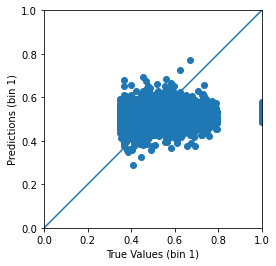

In [56]:
reload(plt)

a = plt.axes(aspect='equal')
plt.scatter(ex1, test_predictions_1)
plt.xlabel('True Values (bin 1)')
plt.ylabel('Predictions (bin 1)')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)